# 3b. Fitting carbonate and SO$_2$ peaks
- This notebook shows how to fit secondary peaks, such as carbonate and S-rich phases in vapour bubbles and fluid inclusions

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
from tqdm import tqdm
pf.__version__

'1.0.5'

In [20]:
# Here, we are loading in the settings files from Step1. If all you want to do is find secondary phases, paste that code here
meta_path, spectra_path, spectra_filetype, prefix, str_prefix, spectra_file_ext, meta_file_ext, TruPower=pf.get_settings()

In [21]:
exclude_str=['Ne', 'NE', 'Si', 'nodiad', 'diad', 'CRR', 'secphase','Series','unquant','Series','map','ol','away','broad','notFI']
Diad_Files=pf.get_files(path=spectra_path, file_ext=spectra_file_ext, exclude_str=exclude_str)
print(Diad_Files)
File_df=pd.DataFrame(data={'filename': Diad_Files})

['06 K21-51rep1.txt', '07 K21-51rep2.txt', '08 K21-51rep3.txt', '12 K21-53-FI#2.txt', '16 K21-53-FI#4.txt', '18 K21-54-FI#2.txt', '21 K21-54-FI#4.txt', '22 K21-55-FI#1.txt', '25 K21-56-FI#1.txt', '27 K21-57-FI#1.txt', '28 K21-57-FI#2.txt', '29 K21-57-FI#3.txt', '30 K21-57-FI#4.txt', '32 K21-58-FI#1-20mw.txt', '33 K21-58-FI#2.txt', '34 K21-58-FI#1-12mw.txt', '35 K21-58-FI#3.txt']


## Plot spectra in a given region of space to examine secondary peaks or not

### You'll need to tweak the peak parameters to find them
- height = minimum height a peak should have to be identified
- threshold = required vertical distance between a peak and its neighbours
- distance = required horizontal distance bewteen neighbouring peaks. 
- prominence = required prominence of peaks
- width = width of peaks


## Example 1 - Using Scipy find peaks to look for SO2

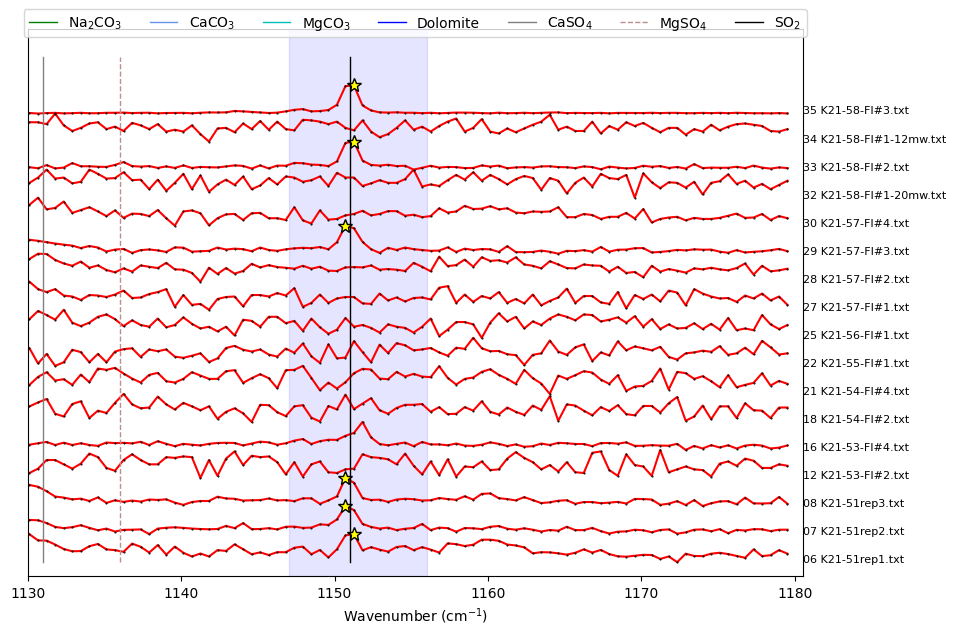

In [22]:
prominence_SO2=5
height_SO2=5
width_SO2=2
threshold_SO2=0

SO2_peaks_scipy, x_data_scipy, y_data_scipy, fig_scipy=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
filetype=spectra_filetype, find_peaks_filter=True,  
xlim_peaks=[1147, 1156], xlim_plot=[1130, 1180], yscale=0.3,
prominence=prominence_SO2, height=height_SO2, width=width_SO2, threshold=threshold_SO2)

SO2_peaks=SO2_peaks_scipy

In [23]:
SO2_peaks

,pos,height,prom,file_names
0,1151.265577,809.799988,14.299988,06 K21-51rep1.txt
1,1150.710207,731.200012,30.900024,07 K21-51rep2.txt
2,1150.710207,739.599976,27.999970,08 K21-51rep3.txt
3,NaN,NaN,NaN,12 K21-53-FI#2.txt
4,NaN,NaN,NaN,16 K21-53-FI#4.txt
5,NaN,NaN,NaN,18 K21-54-FI#2.txt
6,NaN,NaN,NaN,21 K21-54-FI#4.txt
7,NaN,NaN,NaN,22 K21-55-FI#1.txt
8,NaN,NaN,NaN,25 K21-56-FI#1.txt
9,NaN,NaN,NaN,27 K21-57-FI#1.txt


### Now filter out ones with no peaks, or low prominence before we loop through them

In [24]:
# Remove the ones where it didnt find SO2
SO2_notNa=np.isnan(SO2_peaks['pos'])
# Remove ones with a prominence less than this. 
prom_filt=4
SO2_filter=((SO2_peaks['prom']>prom_filt))&(~SO2_notNa)&(~SO2_peaks['file_names'].str.contains("30|31"))
print('Number kept with this filter:')
print(sum(SO2_filter))
print('Number discarded:')
print(sum(~SO2_filter&(~SO2_notNa)))
filenames_SO2=list(File_df['filename'].loc[SO2_filter])
print('filenames with SO2:')
print(filenames_SO2)

Number kept with this filter:
6
Number discarded:
0
filenames with SO2:
['06 K21-51rep1.txt', '07 K21-51rep2.txt', '08 K21-51rep3.txt', '29 K21-57-FI#3.txt', '33 K21-58-FI#2.txt', '35 K21-58-FI#3.txt']


### Choose a filename to test peak fits

In [25]:
if sum(SO2_filter)>0:
    filename=filenames_SO2[0]

### Set up configuration file for S peak fitting
- Here, we are using a spline to quantify the area down to the 92% of the peak height (int_cut_of=0.08), there are differen options you can use for this

generic_peak_config(name='SO2', lower_bck=[1125, 1140], upper_bck=[1165, 1170], model_name='Spline', x_range_bck=20, N_poly_carb_bck=1, amplitude=1000, cent=1150, outlier_sigma=12, distance=10, prominence=5, width=6, threshold=0.1, height=100, exclude_range=[1130, 1135], return_other_params=False, N_peaks=1, int_cut_off=0.05)


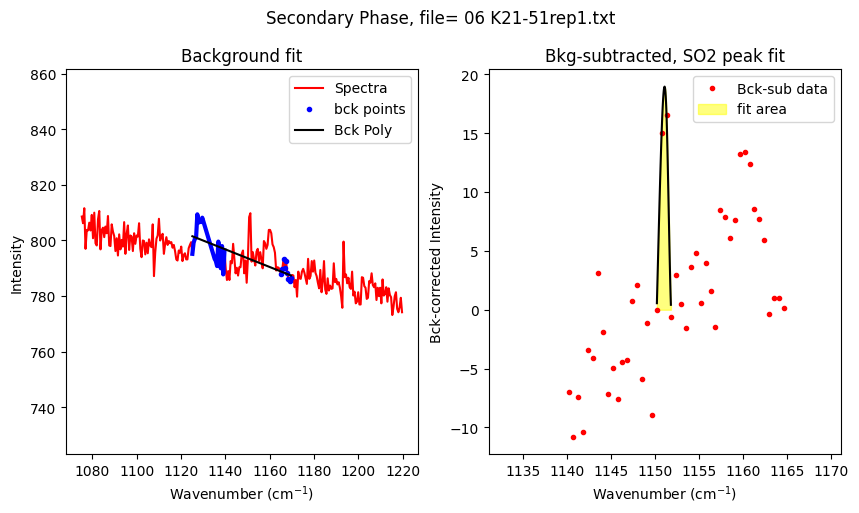

In [26]:
if sum(SO2_filter)>0:
    SO2_peak_config=pf.generic_peak_config(name='SO2', lower_bck=[1125, 1140],
    upper_bck=[1165, 1170], exclude_range=[1130,1135],cent=1150, x_range_bck=20, N_peaks=1,   model_name='Spline', int_cut_off=0.05)
    print(SO2_peak_config)

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
    path=spectra_path, filename=filename, filetype=spectra_filetype, 
     plot_figure=True)

## Now lets loop through files

100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


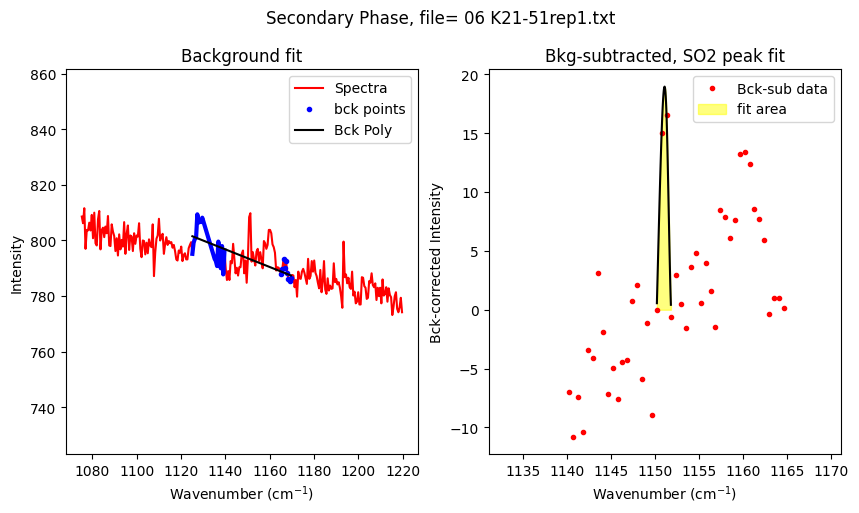

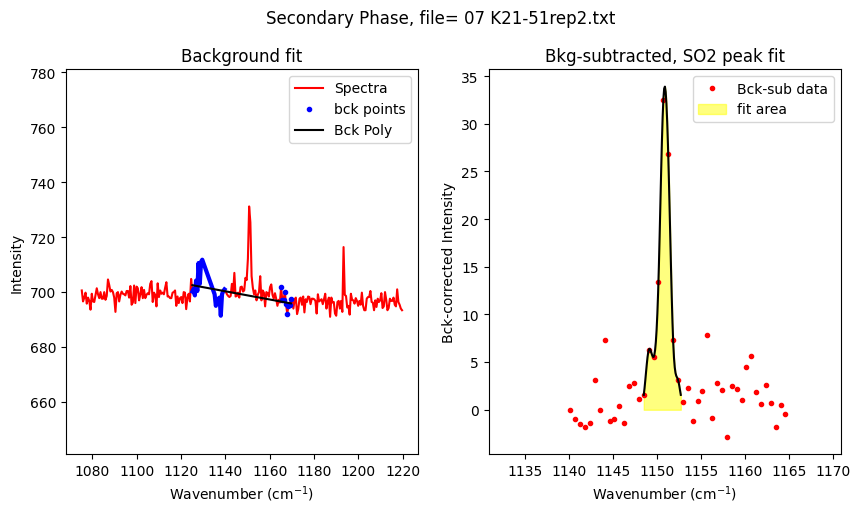

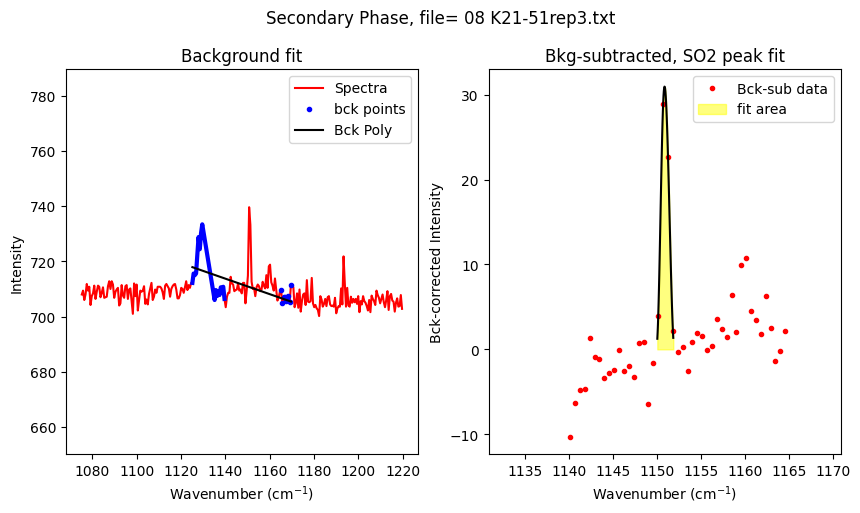

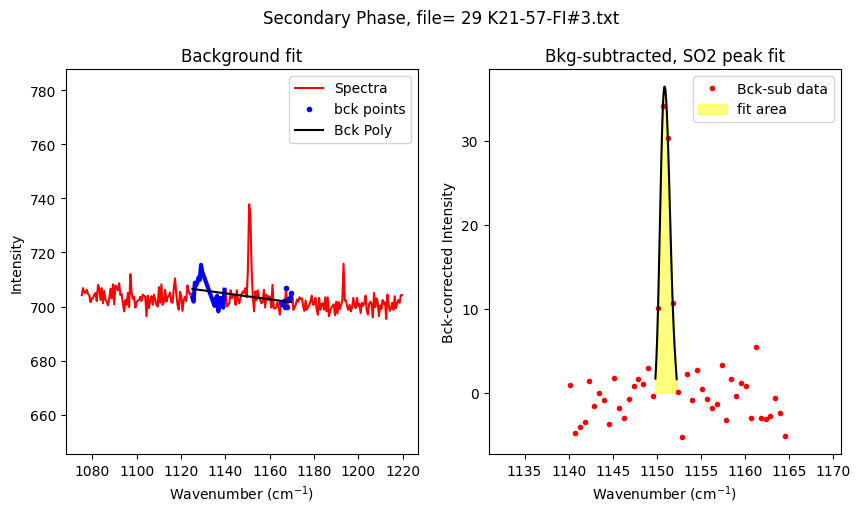

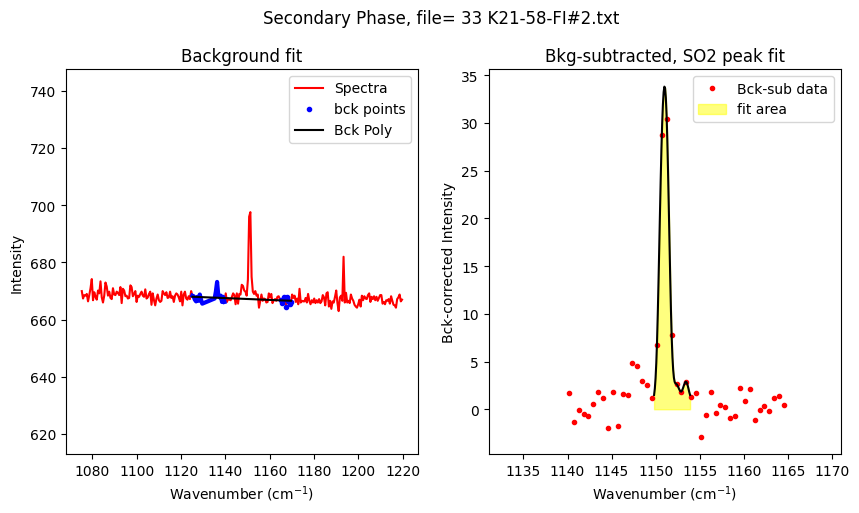

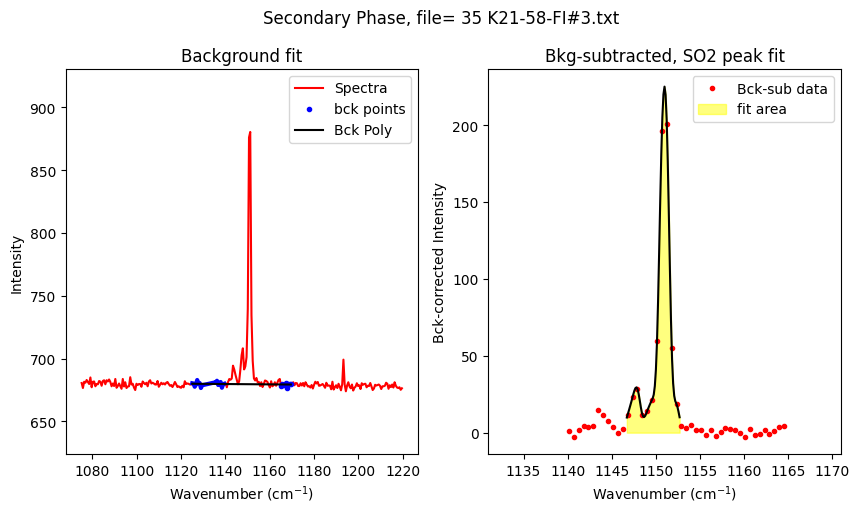

In [27]:
files_to_fit=filenames_SO2
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_SO2 = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
path=spectra_path, filename=filename, filetype=spectra_filetype,
 plot_figure=plot_figure)
 
    df_Merge_SO2 = pd.concat([df_Merge_SO2, SO2_peak_fit], axis=0)

In [28]:
df_Merge_SO2

,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name
0,06 K21-51rep1.txt,1151.054044,18.457588,16.571254,Spline
0,07 K21-51rep2.txt,1150.858408,53.293647,32.503523,Spline
0,08 K21-51rep3.txt,1150.882863,32.057406,28.875687,Spline
0,29 K21-57-FI#3.txt,1150.907317,47.466507,34.116734,Spline
0,33 K21-58-FI#2.txt,1151.029590,45.279336,30.407630,Spline
0,35 K21-58-FI#3.txt,1151.005135,354.673110,200.763861,Spline


### Plot peak areas and peak heights

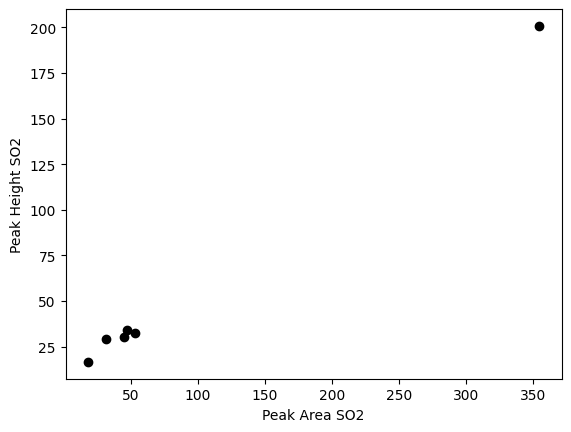

In [29]:
if sum(SO2_filter)>0:
    plt.plot(df_Merge_SO2['Peak_Area_SO2'], 
            df_Merge_SO2['Peak_Height_SO2'], 'ok')
    plt.xlabel('Peak Area SO2')
    plt.ylabel('Peak Height SO2')
    # plt.yscale('log')
# plt.xscale('log')

### Save this to excel

In [30]:
if sum(SO2_filter)>0:
    df_Merge_SO2['filename'] = df_Merge_SO2['filename'].str.replace('--Spec.Data 1', '')
    df_Merge_SO2.to_excel('SO2_Peak_fits.xlsx', index=False)

## Now do the same to ID any carbonate peaks

### Using scipy find peaks methods
- This method doesnt always work perfectly for broader carbonate peaks

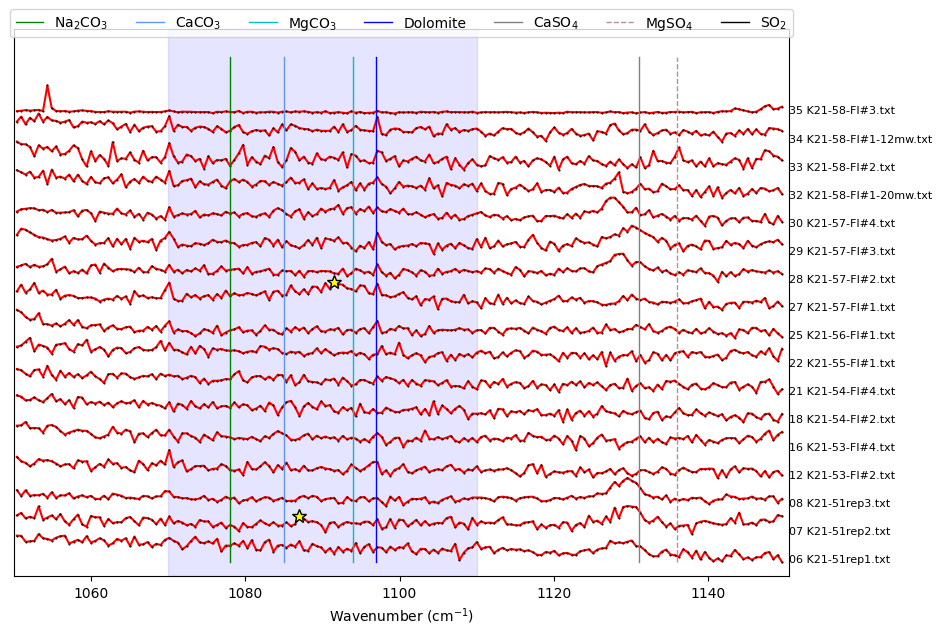

In [31]:

prominence_carb=10
height_carb=10
width_carb=4
threshold_carb=1

Carb_peaks_scipy, x_data_scipy, y_data_scipy, fig=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
 filetype=spectra_filetype, find_peaks_filter=True,  
xlim_plot=[1050, 1150], xlim_peaks=[1070, 1110], yscale=0.3,
prominence=prominence_carb, height=height_carb, width=width_carb, threshold=threshold_carb)
Carb_peaks=Carb_peaks_scipy

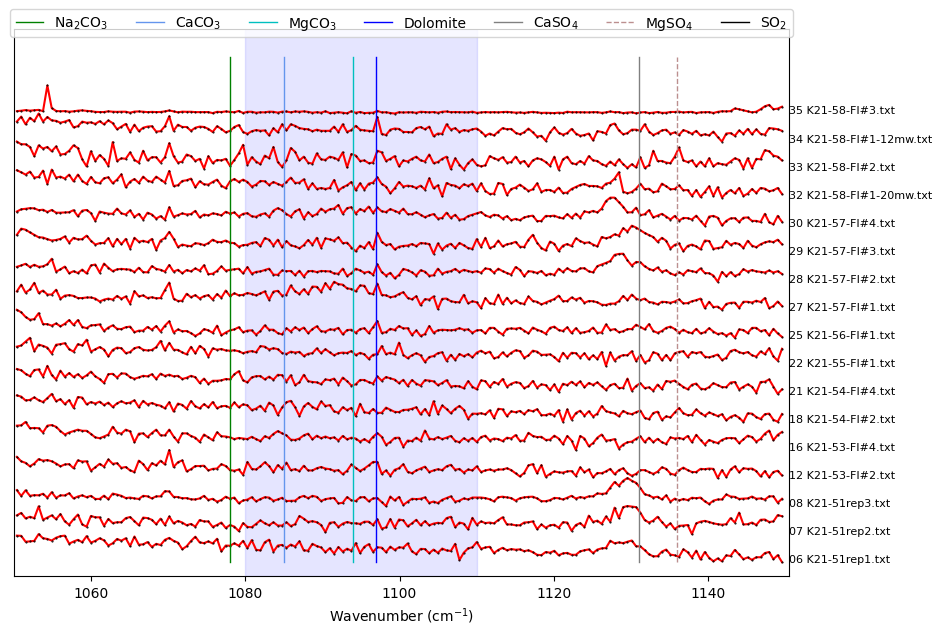

In [32]:

prominence_carb=30
height_carb=10
width_carb=4
threshold_carb=1

Carb_peaks_prom, x_data_prom, y_data_prom, fig=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
 filetype=spectra_filetype, prominence_filter=True,  
xlim_plot=[1050, 1150], xlim_peaks=[1080, 1110], yscale=0.3,
prominence=prominence_carb, height=height_carb, width=width_carb, threshold=threshold_carb)

# Carb_peaks=Carb_peaks_prom

In [33]:
Carb_peaks

,pos,height,prom,file_names
0,NaN,NaN,NaN,06 K21-51rep1.txt
1,1087.023536,704.599976,4.599976,07 K21-51rep2.txt
2,NaN,NaN,NaN,08 K21-51rep3.txt
3,NaN,NaN,NaN,12 K21-53-FI#2.txt
4,NaN,NaN,NaN,16 K21-53-FI#4.txt
5,NaN,NaN,NaN,18 K21-54-FI#2.txt
6,NaN,NaN,NaN,21 K21-54-FI#4.txt
7,NaN,NaN,NaN,22 K21-55-FI#1.txt
8,NaN,NaN,NaN,25 K21-56-FI#1.txt
9,1091.517061,712.200012,13.600037,27 K21-57-FI#1.txt


## Find ones with certain peak parameters to include

In [46]:
Carb_noNa=np.isnan(Carb_peaks['pos'])
prom_filter=5
Carb_filter=((Carb_peaks['prom']>prom_filter))&(~Carb_noNa)&(~Carb_peaks['file_names'].str.contains('KD24'))
print('Number kept with this filter:')
print(sum(Carb_filter))
print('Number discarded:')
print(sum(~Carb_filter&(~Carb_noNa)))
filenames_Carb=list(File_df['filename'].loc[Carb_filter])
print('filenames with carb:')
print(filenames_Carb)

Number kept with this filter:
1
Number discarded:
1
filenames with carb:
['27 K21-57-FI#1.txt']


### Fit one to tweak parameters

generic_peak_config(name='Carb', lower_bck=[1050, 1065], upper_bck=[1119, 1150], model_name='Spline', x_range_bck=50, N_poly_carb_bck=2, amplitude=1000, cent=1090, outlier_sigma=12, distance=10, prominence=5, width=6, threshold=0.1, height=100, exclude_range=None, return_other_params=False, N_peaks=1, int_cut_off=0.05)


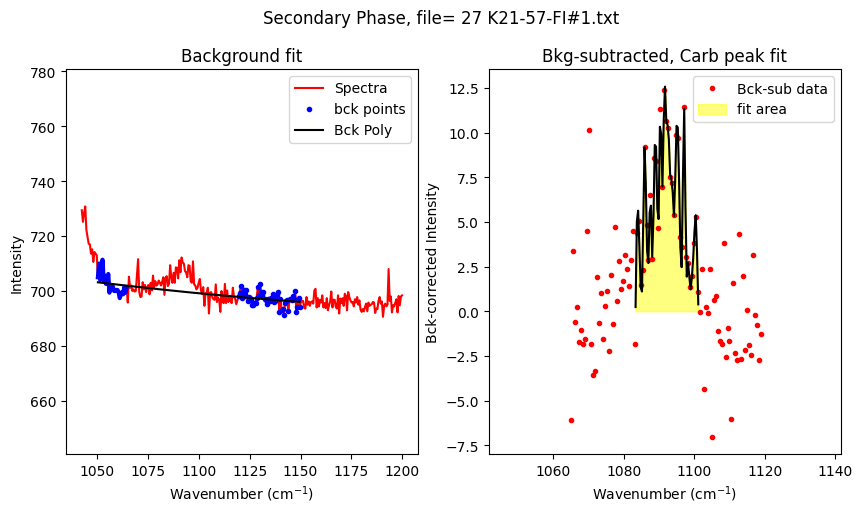

In [47]:
if sum(Carb_filter)>0:
    filename_carb=filenames_Carb[0]

    Carb_peak_config=pf.generic_peak_config(name='Carb', lower_bck=[1050, 1065],
    upper_bck=[1119, 1150], cent=1090, x_range_bck=50, N_poly_carb_bck=2, model_name='Spline')
    print(Carb_peak_config)

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
    path=spectra_path, filename=filename_carb, filetype=spectra_filetype,
     plot_figure=True)

### Loop over all carbonate files

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


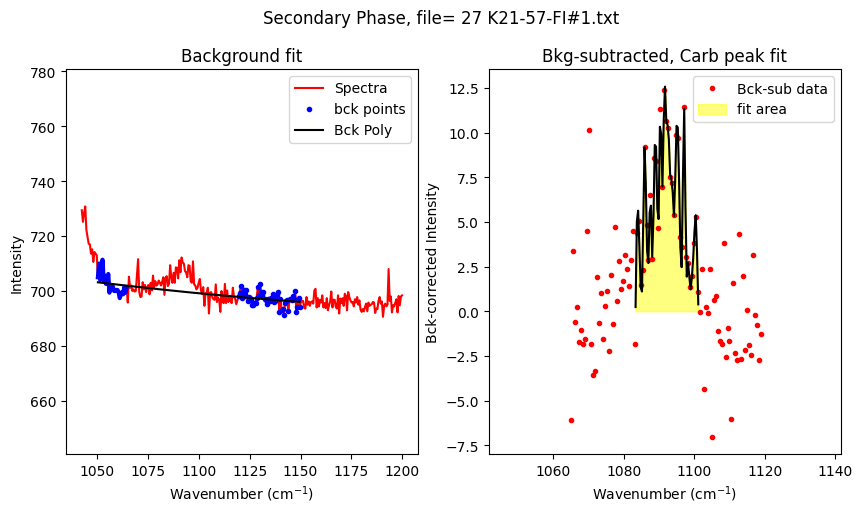

In [48]:
files_to_fit=filenames_Carb
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_Carb = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
path=spectra_path, filename=filename, filetype=spectra_filetype,
 plot_figure=plot_figure)
 
    df_Merge_Carb = pd.concat([df_Merge_Carb, Carb_peak_fit], axis=0)

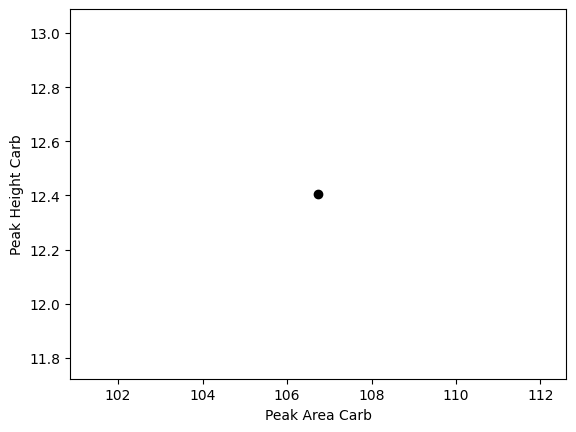

In [49]:
if sum(Carb_filter)>0:
    plt.plot(df_Merge_Carb['Peak_Area_Carb'], 
        df_Merge_Carb['Peak_Height_Carb'], 'ok')
    plt.xlabel('Peak Area Carb')
    plt.ylabel('Peak Height Carb')
# plt.yscale('log')
# plt.xscale('log')

## Save to excel

In [50]:
if sum(Carb_filter)>0:
    df_Merge_Carb['filename'] = df_Merge_Carb['filename'].str.replace('--Spec.Data 1', '')
    df_Merge_Carb.to_excel('Carb_Peak_fits.xlsx', index=False )

In [51]:
df_Merge_Carb

,filename,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name
0,27 K21-57-FI#1.txt,1091.607751,106.739735,12.405787,Spline


In [52]:
import os

if os.name=="posix":

    def mac_notification(title, subtitle, message):
        """
        Display a macOS notification with the default sound using AppleScript.
        
        Args:
        - title: Title of the notification.
        - subtitle: Subtitle of the notification.
        - message: Main message content of the notification.
        """
        os.system("""
                osascript -e 'display notification "{}" with title "{}" subtitle "{}" sound name "default"'
                """.format(message, title, subtitle))

    mac_notification("Notebook Completed", "VSCode", "Step3b Secondary peaks")

else:

    # %pip install winotify

    from winotify import Notification, audio

    toast= Notification(app_id="VSCode",title="Notebook completed",
                        msg="Step3b_Secondary_Peaks is done!",
                        duration="short")
    toast.set_audio(audio.Mail,loop=False)
    toast.show()